In [285]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 15})

In [284]:
#Accesses .csv file in case of network emergencies

import numpy as np
import pylab as pl
from scipy.signal import savgol_filter

data = np.genfromtxt('delayMeanSixMonths.csv',delimiter=',',skip_header = 1)
epochTime = data[:,0]
delayMean = data[:,1]

#Get times that have values
indices = np.logical_not(np.isnan(delayMean))
delayMean = delayMean[indices]
epochTime = epochTime[indices]
monthTime = epochTime/(1000*60*60*24*30)

In [286]:

query1 = {
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "srcSite:CERN* AND destSite:BNL* AND delay_mean:>0",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": 1452612045688,
                  "lte": 1468333245688,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "3": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "1h",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": 1452612045687,
          "max": 1468333245687
        }
      },
      "aggs": {
        "2": {
          "avg": {
            "field": "delay_mean"
          }
        }
      }
    }
  }
}

#Get delay 
response = es.search(index="network_weather_2-*", body=query1, request_timeout=600)

In [277]:
delayMean = []
epochTime = []
for r in response['aggregations']['3']['buckets']:
    #Get field value and timestamp
    delayMean.append(r['2']['value'])
    epochTime.append(r['key'])

#Get times that have values
delayMean = np.array(delayMean)
epochTime = np.array(epochTime)

indices = np.logical_not(np.isnan(delayMean))

delayMean = delayMean[indices]
epochTime = epochTime[indices]

monthTime = epochTime/(1000*60*60*24*30)

#Filter outliers
#filterOutliers = 3*np.std(delayMean)
#centered = delayMean - np.mean(delayMean)
#indices2 = np.abs(centered) < filterOutliers

#delayMean = delayMean[indices2]
#monthTime = monthTime[indices2]

The cell below grabs 70% of the total dataset as a random sample to perform linear regression. Then the remaining 30% is compared to the linear fit, and the root-mean-squared error is reported. This process is repeated several times, each time grabbing new random samples for the training and test set, while maintaining the same 70/30 ratio.
The results are graphed.

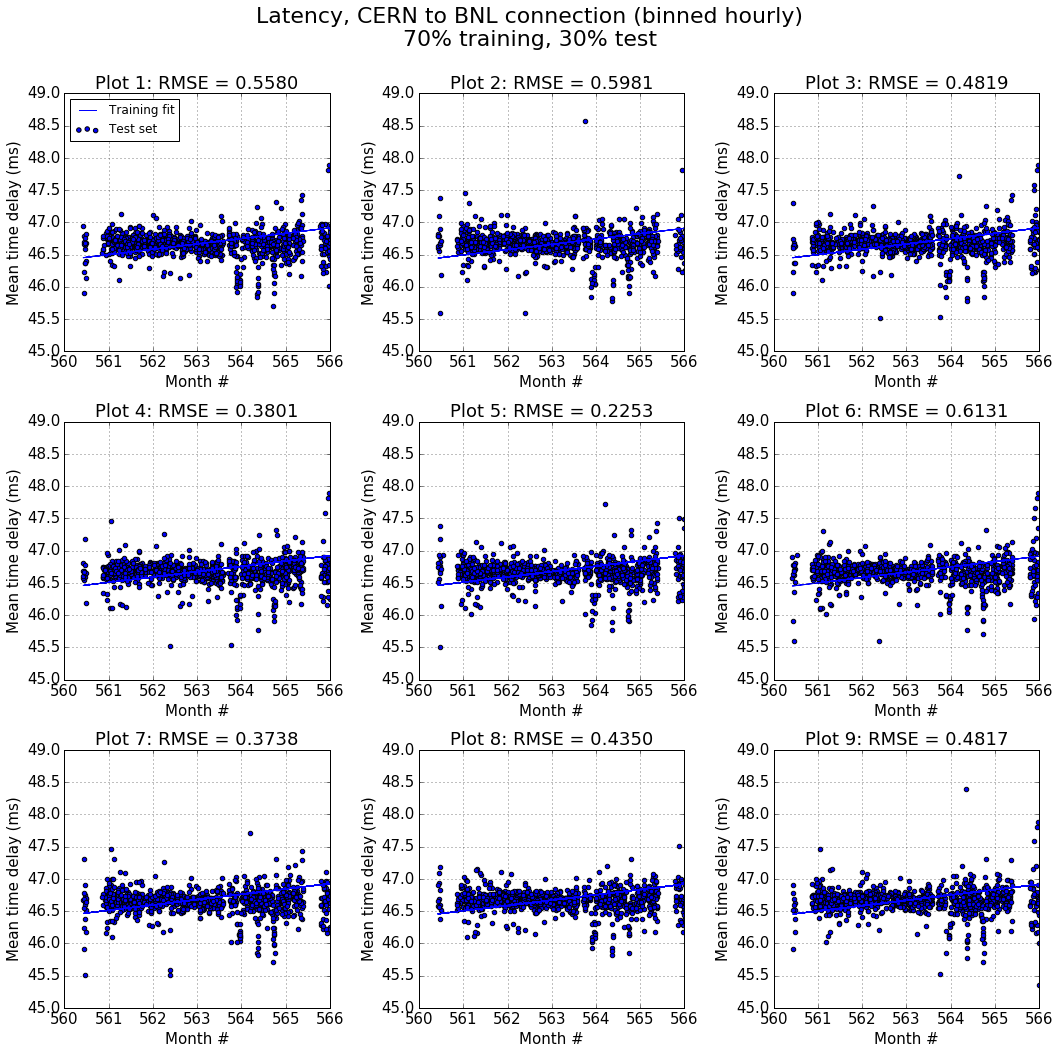

In [278]:
import matplotlib.pyplot as plt
from sklearn import cross_validation,linear_model
import matplotlib.dates as dt

xTrainSamples = []
xTestSamples = []
yTrainSamples = []
yTestSamples = []
regressionSet = []


coefficientSet = []
rmseSet = []
varianceSet = []

plt.figure(figsize=(15,15))
for i in range(9):
    
    #Build training sets, randomly sampled from data; reseeded based on index
    xTrain, xTest, yTrain, yTest = cross_validation.train_test_split(monthTime,delayMean,
                                                                        test_size=0.3,random_state = i)
    
    #Reshape for LinearRegression function
    xTrain = xTrain.reshape(-1,1)
    xTest = xTest.reshape(-1,1)
    # Create linear regression object, and do not subtract the mean
    regr = linear_model.LinearRegression(fit_intercept=False)
    # Train the model using the training sets
    regr.fit(xTrain, yTrain)
    
    
    coefficientSet.append(regr.coef_)
    regressionSet.append(regr)
    
    #Get mean squared error and store it
    rmseSet.append(np.sqrt(np.mean((regr.predict(xTest) - yTest) ** 2)))
    
    #Get variance and store it
    varianceSet.append(regr.score(xTest, yTest))
    xTrainSamples.append(xTrain)
    xTestSamples.append(xTest)
    yTrainSamples.append(yTrain)
    yTestSamples.append(yTest)
    
    yPredict = regr.predict(xTest)
    #Plot test sample with predicted line
    plt.subplot(3,3,i+1)
    plt.plot(xTest, yPredict, color='blue',
         linewidth=1,label='Training fit')

    plt.title('Plot %i: RMSE = %.4f'%(i+1,rmseSet[i]))
    plt.scatter(xTest,yTest,label='Test set')
    if i ==0:
        plt.legend(loc=2,prop={'size':12})
    plt.ylabel('Mean time delay (ms)')
    plt.xlabel('Month #')
    plt.ylim(45,49)
    plt.xlim(560,566)
    plt.grid()

plt.suptitle('Latency, CERN to BNL connection (binned hourly)\n70% training, 30% test',size=22)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

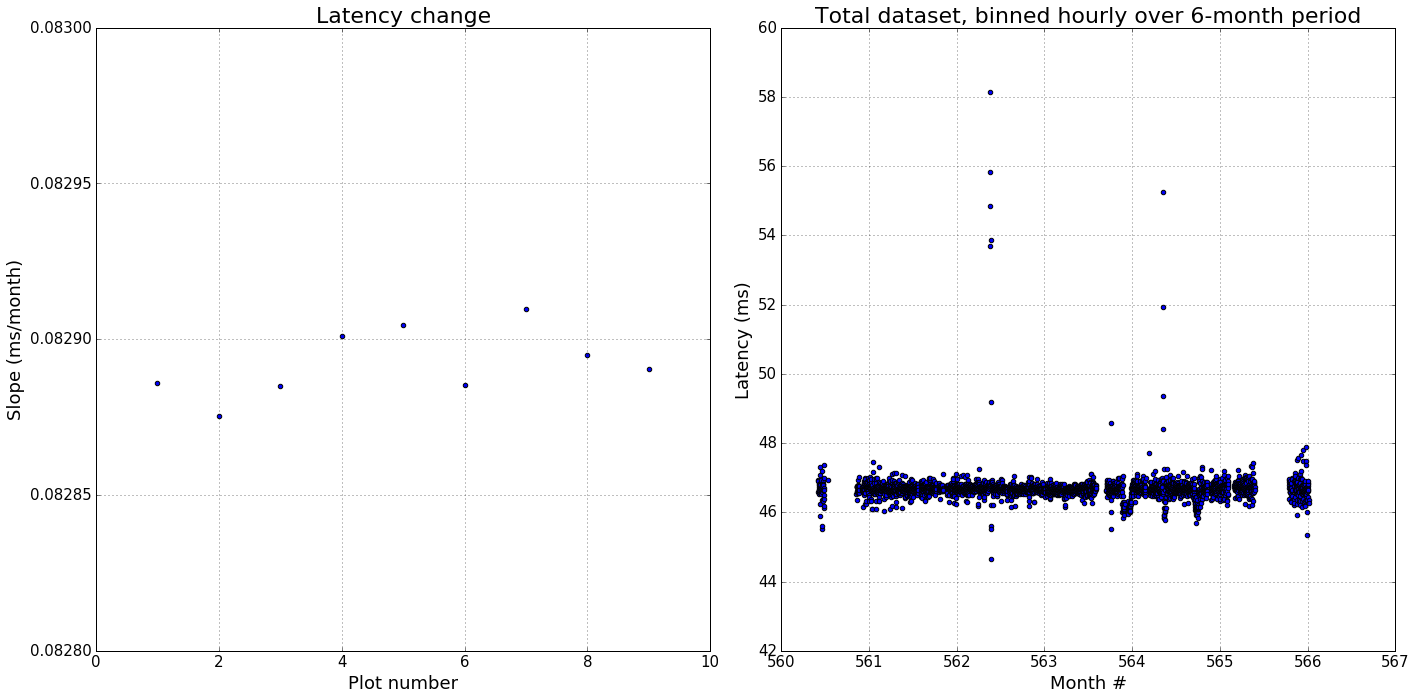

In [279]:
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.scatter(range(1,10),coefficientSet)
plt.xlabel('Plot number',size=18)
plt.ylabel('Slope (ms/month)',size=18)
plt.ylim(0.0828,.083)
plt.grid()
plt.title('Latency change',size=22)


plt.subplot(122)
plt.scatter(monthTime,delayMean)
plt.title('Total dataset, binned hourly over 6-month period',size=22)
plt.xlabel('Month #',size=18)
plt.ylabel('Latency (ms)',size=18)
plt.grid()
plt.tight_layout()

In [280]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

#Get indices for network_weather_2-*
indices = es.cat.indices(index="network_weather_2-*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

#print(indices)

In [287]:
query2 = {
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False,
          "query": "srcSite:CERN* AND destSite:*  AND delay_mean:>0"
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": 1452612045688,
                  "lte": 1468333245688,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "3": {
      "terms": {
        "field": "destSite",
        "size": 60,
        "order": {
          "2": "desc"
        }
      },
      "aggs": {
        "2": {
          "avg": {
            "field": "delay_mean"
          }
        },
        "4": {
          "avg": {
            "field": "delay_sd"
          }
        }
      }
    }
  }
}
response = es.search(index="network_weather_2-*", body=query2, request_timeout=600)

In [288]:
delayMean = []
delayStd = []
linkName = []
for r in response['aggregations']['3']['buckets']:
    #Get field value and timestamp
    delayMean.append(r['2']['value'])
    delayStd.append(r['4']['value'])
    linkName.append(r['key'])


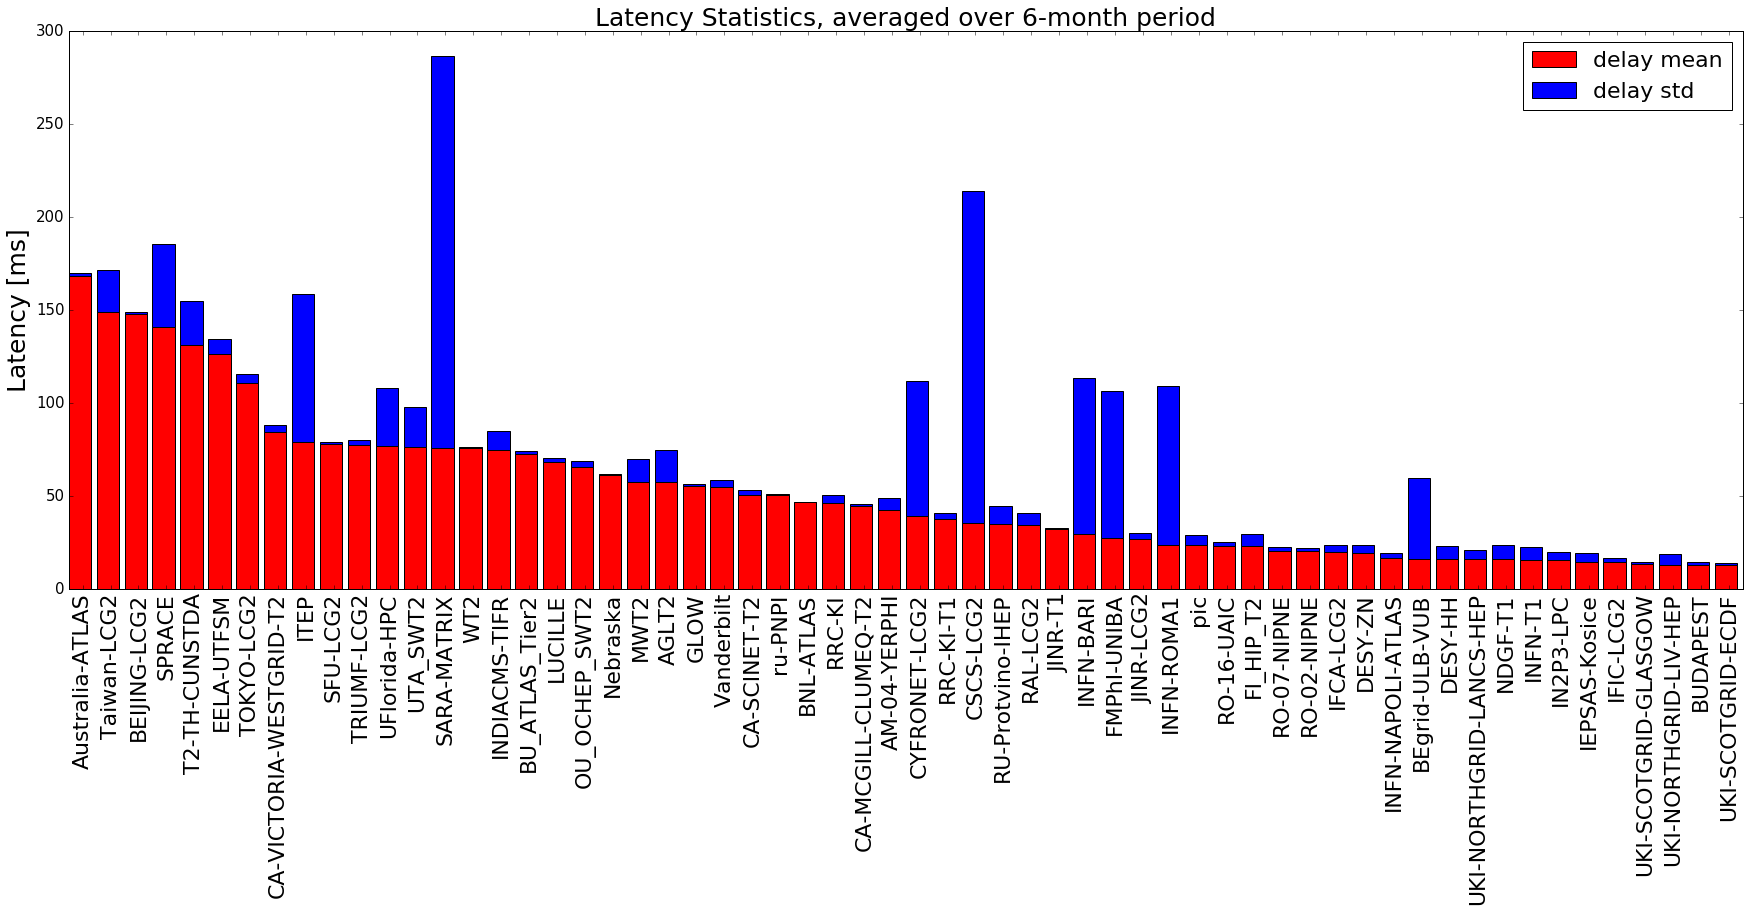

In [289]:
plt.figure(figsize=(30,10))

ax = plt.gca()
ax.bar(range(len(delayMean)),delayMean, label='delay mean',color='r')
ax.bar(range(len(delayMean)),delayStd, bottom=delayMean, label='delay std',color='b')

ax.xaxis.set_ticks(np.arange(0.5,len(delayMean)+0.5))
ax.xaxis.set_ticklabels(linkName)
plt.xticks(size=22,rotation= 90)
plt.title('Latency Statistics, averaged over 6-month period',size=25)
plt.ylabel('Latency [ms]',size=25)
plt.legend(prop={'size':22})
plt.show()